# PROJET D'OPTIMISATION - GRP 4 

## Restauration d'images 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

### Question 1

_(Réponses aux questions théoriques)_

### Question 4

[[0.20392157 0.20392157 0.20392157 ... 0.34509804 0.34509804 0.35294118]
 [0.2        0.2        0.20784314 ... 0.34509804 0.34509804 0.35294118]
 [0.19607843 0.20392157 0.21176471 ... 0.35294118 0.35294118 0.36078431]
 ...
 [0.18823529 0.17647059 0.19215686 ... 0.07058824 0.0745098  0.0745098 ]
 [0.18823529 0.17647059 0.19215686 ... 0.0745098  0.0745098  0.0745098 ]
 [0.18431373 0.17647059 0.18823529 ... 0.0745098  0.0745098  0.0745098 ]]


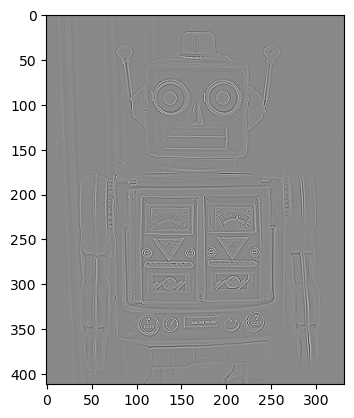

In [2]:
def grad(u):
    """Computes the discrete gradient of a (n x m) matrix."""
    
    (n, m) = u.shape
    grad = np.zeros((n,m,2))

    grad[:n-1,:,0] = u[1:n, :] - u[0:n-1, :]
    grad[:,:m-1,1] = u[:, 1:m] - u[:, 0:m-1]

    return grad

def div(v):
    """Computes the discrete divergence of a vector of size (n x m x 2)."""
    
    (n, m) = v.shape[:2]  # v is a vector of size n x m x 2
    v_x = v[:, :, 0]
    v_y = v[:, :, 1]
    div = np.zeros((n, m))
    
    div[0, :] += v_x[0, :]
    div[n-1, :] += -v_x[n-2, :]
    div[1:n-1, :] += (v_x[1:n-1, :] - v_x[0:n-2, :])
    
    div[:, 0] += v_y[:, 0]
    div[:, m-1] += -v_y[:, m-2]
    div[:, 1:m-1] += (v_y[:, 1:m-1] - v_y[:, 0:m-2])
    
    return div

def display(image):
    # Rescaling values from 0 to 1
    image = (image - np.min(image))/(np.max(image) - np.min(image))
    (n, m) = image.shape[:2]

    # Copying each value to a tuple
    gray_im = np.zeros((n,m,3))
    gray_im[:,:,0] = image
    gray_im[:,:,1] = image
    gray_im[:,:,2] = image

    plt.imshow(gray_im)


u = plt.imread("./robot_no_noise.jpg")
u = u[:,:,0]/255

laplacian = div(grad(u))  
display(laplacian)
print(u)

### Question 5 
_Algorithme de descente de gradient à pas fixe_

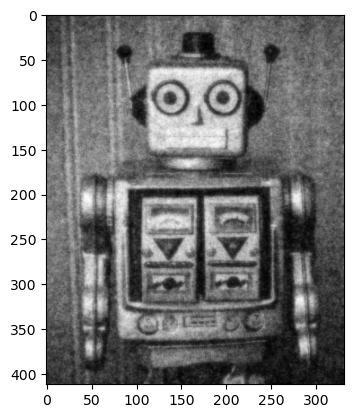

In [3]:
u_b = plt.imread("./robot_noise.jpg")[:,:,0]/255

def grad_f(u: np.ndarray) -> np.ndarray:
    """Returns the gradient of function f at matrix u."""
    return (u - u_b - 2*div(grad(u)))

def grad_descent(z0: np.ndarray, step: float, eps: float=1e-4, n_max: int=100) -> np.ndarray:
    """Implements the gradient descent algorithm with a constant step."""
    z = z0
    n = 0

    while np.linalg.norm(grad_f(z), ord='fro') >= eps and n <= n_max:
        z = z - step * grad_f(z)
    
    return z

# Restoration
u_rest = grad_descent(u_b, step=1e-2)  # Pour l'instant, le pas est choisi au hasard.
                                # => Algorithme pour respecter Wolfe?
display(u_rest)


### Question 6

_Quantification de l'écart_

In [4]:
def RMSE(z: np.ndarray) -> float:
    (n,m) = u.shape
    return (np.sqrt(np.linalg.norm(u-z, ord='fro')/(n*m))) # Frobenius norm

print(f"RMSE de l'image restaurée : {RMSE(u_rest)}")
print(f"RMSE de l'image bruitée : {RMSE(u_b)}")

RMSE de l'image restaurée : 0.016151110869360795
RMSE de l'image bruitée : 0.022382607219252525


On restaure donc légèrement l'image bruitée, mais c'est encore insatisfaisant.

### Question 7

_Comparaison à la bibliothèque Scipy_

In [7]:
(n,m) = u.shape
u_b2 = u_b.reshape(u_b.size) # reformatting to scalar
u2 = u.reshape(u.size)

def grad_to_vector(matrix: np.ndarray):
    gradient = grad(matrix)
    return (gradient.reshape(gradient.size))

def f(u: np.ndarray) -> float:
    """Cost function"""
    # using grad function
    matrix = u.reshape((n,m))
    g = grad_to_vector(matrix)

    return(0.5*np.dot(u-u_b2,u-u_b2) + np.dot(g,g))

u_rest2 = scipy.optimize.minimize(f,u_b2)


: 